<a href="https://colab.research.google.com/github/Daniblue25/Fianko-kossi/blob/main/LSTM_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series temporelles

In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import datetime

In [2]:
import seaborn as sns
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("TCEHY.csv", parse_dates=True, index_col= 0)
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2020-05-21 to 2023-05-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       755 non-null    float64
 1   High       755 non-null    float64
 2   Low        755 non-null    float64
 3   Close      755 non-null    float64
 4   Adj Close  755 non-null    float64
 5   Volume     755 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB
None


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-21,55.020000,55.459999,54.709999,55.150002,51.607403,5413200
2020-05-22,53.410000,53.459999,52.400002,52.680000,49.296062,8033300
2020-05-26,55.009998,55.049999,53.849998,53.910000,50.447052,5106100
2020-05-27,53.919998,54.000000,53.000000,53.580002,50.138256,4612200
2020-05-28,52.939999,53.139999,52.250000,52.250000,48.893692,4071300


In [4]:
X = df['Close']

# **Analyse** **Univariée** 

(array([18383., 18506., 18628., 18748., 18871., 18993., 19113., 19236.,
        19358., 19478.]),
 [Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05')])

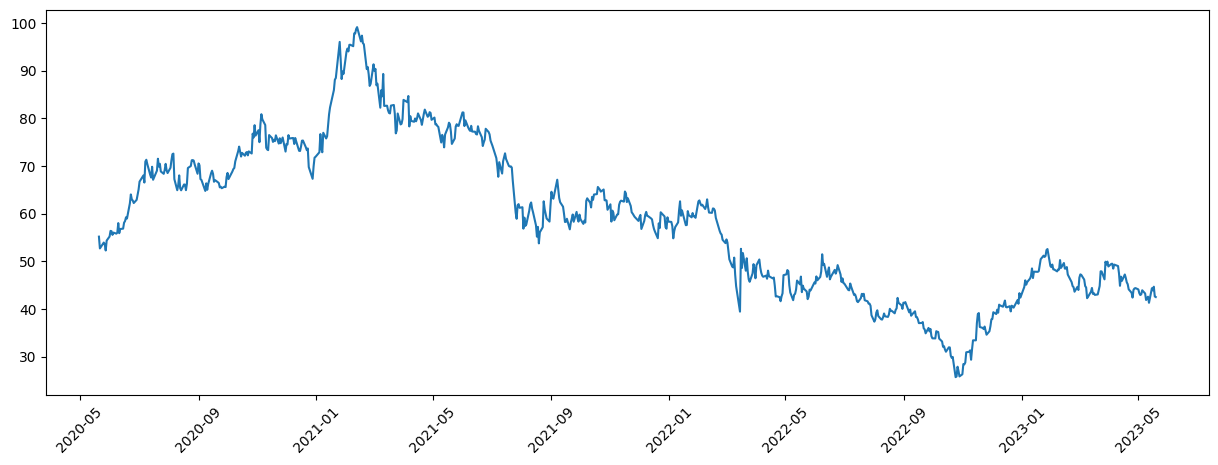

In [5]:
plt.figure(figsize =(15,5))
plt.plot(X)
plt.xticks(rotation = 45)

In [6]:
# Normalisation des données
X = X.values.astype('float32').reshape(-1,1)

In [7]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [8]:
train_size = int(len(X) *.80)
test_size = len(X) - train_size
train, test = X[0:train_size, :], X[train_size:len(X),:]

In [9]:
# Transformation de data pour l'adapter au cellules recurrentes

from keras.preprocessing.sequence import TimeseriesGenerator
seq_size = length = 10
batch_size = 1
train_generator = TimeseriesGenerator(train, train, length= length, stride= 1, batch_size= batch_size)
print("Nombre d'observation dans l'echantillon d'entrainement = ",len(train))
print("Nombre d'observation dans train generator = ",len(train_generator))

Nombre d'observation dans l'echantillon d'entrainement =  604
Nombre d'observation dans train generator =  594


In [10]:
x, y = train_generator[0]
print(x)
print("pour y",y)

[[[-0.22027469]
  [-0.37600517]
  [-0.29845524]
  [-0.3192612 ]
  [-0.40311617]
  [-0.27260527]
  [-0.2183833 ]
  [-0.14398576]
  [-0.14839914]
  [-0.19694671]]]
pour y [[-0.16668335]]


In [11]:
# Générons un échantillon de validation
validation_generetor = TimeseriesGenerator(test, test, length= length, batch_size= batch_size)
print("Nombre d'observation dans l'echantillon d'validation = ",len(test))
print("Nombre d'observation dans validation generator = ",len(validation_generetor))

Nombre d'observation dans l'echantillon d'validation =  151
Nombre d'observation dans validation generator =  141


In [12]:
# Pour l'analyse univarié on a une seule feature
num_feat = 1

In [13]:
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True, input_shape = (length, num_feat)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam',
              loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Entrenement du modele et prédiction
history = model.fit_generator(generator = train_generator, verbose = 2, epochs =10, validation_data = validation_generetor)


Epoch 1/10
594/594 - 8s - loss: 0.0768 - val_loss: 0.0563 - 8s/epoch - 14ms/step
Epoch 2/10
594/594 - 9s - loss: 0.0339 - val_loss: 0.0321 - 9s/epoch - 15ms/step
Epoch 3/10
594/594 - 10s - loss: 0.0291 - val_loss: 0.0148 - 10s/epoch - 17ms/step
Epoch 4/10
594/594 - 5s - loss: 0.0262 - val_loss: 0.0092 - 5s/epoch - 9ms/step
Epoch 5/10
594/594 - 7s - loss: 0.0227 - val_loss: 0.0187 - 7s/epoch - 12ms/step
Epoch 6/10
594/594 - 9s - loss: 0.0208 - val_loss: 0.0077 - 9s/epoch - 15ms/step
Epoch 7/10
594/594 - 5s - loss: 0.0172 - val_loss: 0.0150 - 5s/epoch - 9ms/step
Epoch 8/10
594/594 - 8s - loss: 0.0199 - val_loss: 0.0081 - 8s/epoch - 13ms/step
Epoch 9/10
594/594 - 7s - loss: 0.0194 - val_loss: 0.0110 - 7s/epoch - 12ms/step
Epoch 10/10
594/594 - 6s - loss: 0.0179 - val_loss: 0.0068 - 6s/epoch - 10ms/step


In [15]:
train_pred = model.predict(train_generator)
test_pred = model.predict(validation_generetor)

141/141 [==============================] - 0s 3ms/step


In [16]:
# Remettre à l'échelle les variables pour les graphiques

train_pred = sc.inverse_transform(train_pred)
y_train_rescaled = sc.inverse_transform(train)

test_pred = sc.inverse_transform(test_pred)
y_test_rescaled = sc.inverse_transform(test)

In [17]:
len(train), len(train_pred)

(604, 594)

In [18]:
# Calcule du RMSE
train_score = math.sqrt(mean_squared_error(y_train_rescaled[length:], train_pred))
print("Score sur l'echantillon d'entrainement : %.2f RMSE" %(train_score))

test_score = math.sqrt(mean_squared_error(y_test_rescaled[length:], test_pred))
print("Score sur l'echantillon test : %.2f RMSE" %(test_score))

Score sur l'echantillon d'entrainement : 1.96 RMSE
Score sur l'echantillon test : 1.30 RMSE


In [19]:
# je dois déplacer les predictions pour les aligner avec le data d'origine sur l'axe x

train_pred_plot = np.empty_like(X)
train_pred_plot[:, :] = np.nan
train_pred_plot[length:len(train_pred) + length, :] = train_pred

# Pour le test
test_pred_plot = np.empty_like(X)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train) + (length) -1 :len(X) -1, :] = test_pred

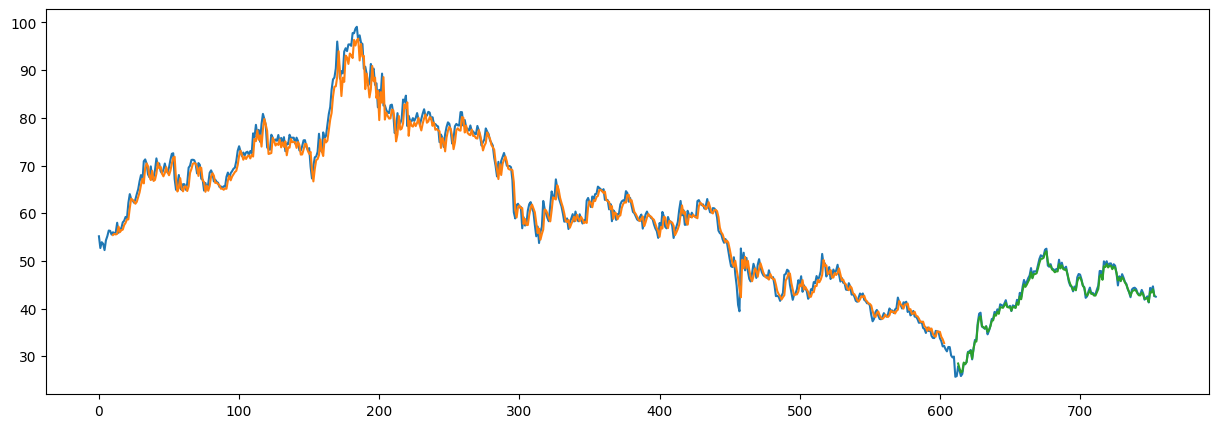

In [20]:
# Graphique des vraies valaurs et des predictions
plt.figure(figsize = (15,5))
plt.plot(sc.inverse_transform(X))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

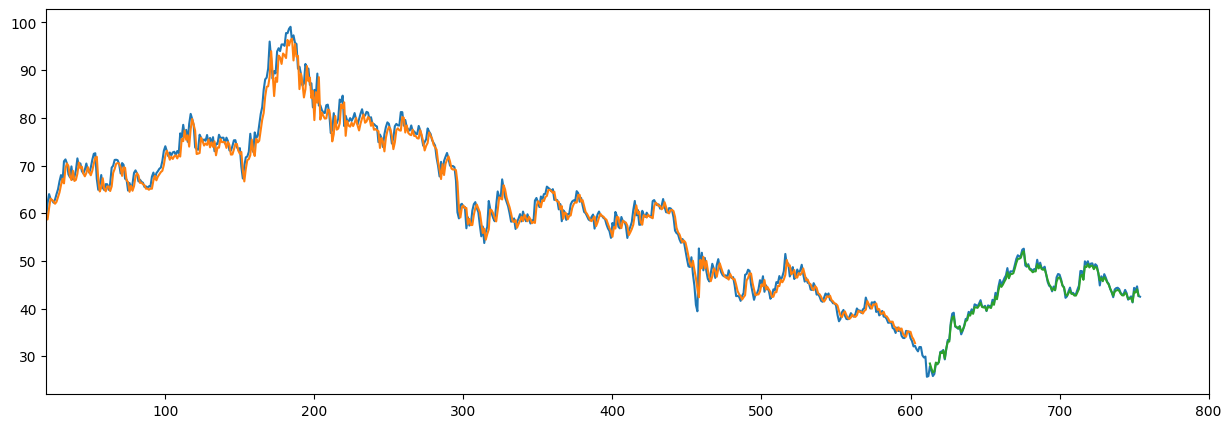

In [21]:
plt.figure(figsize = (15,5))
plt.plot(sc.inverse_transform(X))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.xlim(20,800)
plt.show()

# Analyse mutlivariée

In [22]:
df = pd.read_csv("TCEHY.csv")
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-21,55.020000,55.459999,54.709999,55.150002,51.607403,5413200
1,2020-05-22,53.410000,53.459999,52.400002,52.680000,49.296062,8033300
2,2020-05-26,55.009998,55.049999,53.849998,53.910000,50.447052,5106100
3,2020-05-27,53.919998,54.000000,53.000000,53.580002,50.138256,4612200
4,2020-05-28,52.939999,53.139999,52.250000,52.250000,48.893692,4071300


In [23]:
train_dates = pd.to_datetime(df['Date'])

In [24]:
#Selection des variables utiles
cols = ["Open",'High', 'Low', 'Close']
df_train = df[cols].astype(float)

In [59]:
# Normalisation
scaler = sc.fit(df_train)
# 
df_train_scaled = scaler.transform(df_train)

In [62]:
X_train = []
Y_train = []
n_future = 1  # nbre de jours à predire dans le future
n_past = 14  # nbre de jours sur lesquels on va se basé pour prédire

for i in range(n_past, len(df_train_scaled) - n_future + 1):
  X_train.append(df_train_scaled[i - n_past:i, 0:df_train.shape[1]])
  Y_train.append(df_train_scaled[i + n_future -1 : i + n_future, 0])
  

In [63]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape, Y_train.shape

((741, 14, 4), (741, 1))

In [64]:
X_train[0]

array([[-0.22702239, -0.23778141, -0.20606218, -0.22027465],
       [-0.32851487, -0.36312565, -0.35345446, -0.37600518],
       [-0.2276529 , -0.26347698, -0.26093563, -0.29845522],
       [-0.29636521, -0.32928264, -0.31517083, -0.31926118],
       [-0.35814318, -0.38318072, -0.36302553, -0.40311614],
       [-0.37705482, -0.30233363, -0.34707396, -0.27260524],
       [-0.23963015, -0.24279505, -0.20797631, -0.21838332],
       [-0.16650513, -0.17510929, -0.14799848, -0.14398573],
       [-0.15389737, -0.17260234, -0.12119972, -0.14839915],
       [-0.17659134, -0.19453746, -0.17798724, -0.19694674],
       [-0.15957086, -0.17009539, -0.12375204, -0.16668335],
       [-0.18478645, -0.20895229, -0.17798724, -0.18055413],
       [-0.18604729, -0.1970444 , -0.15884542, -0.16794432],
       [-0.07698989, -0.06480623, -0.05611734, -0.04121622]])

In [65]:
Y_train[0]

array([-0.12552984])

In [67]:
# Transformation de data pour l'adapter au cellules recurrentes

from keras.preprocessing.sequence import TimeseriesGenerator
target = df_train_scaled[:,0]

seq_size = length = 14
batch_size = 16
train_generator_mult = TimeseriesGenerator(df_train_scaled, target, length= length, stride= 1, batch_size= batch_size)
print("Nombre d'observation dans l'echantillon d'entrainement = ",len(df_train))
print("Nombre d'observation dans train generator = ",len(train_generator_mult))

Nombre d'observation dans l'echantillon d'entrainement =  755
Nombre d'observation dans train generator =  47


In [66]:
# Création du modèle
inputs_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences = True, input_shape = inputs_shape))
model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu', return_sequences = True, input_shape = inputs_shape))
model.add(LSTM(32, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 64)            17664     
                                                                 
 dropout_2 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 63,137
Trainable params: 63,137
Non-trai

In [68]:
history = model.fit(X_train, Y_train, epochs = 10, batch_size = batch_size, validation_split=0.1, verbose =1)

Epoch 1/10
42/42 [==============================] - 7s 54ms/step - loss: 0.3901 - val_loss: 0.2414
Epoch 2/10
42/42 [==============================] - 1s 30ms/step - loss: 0.1517 - val_loss: 0.0777
Epoch 3/10
42/42 [==============================] - 1s 23ms/step - loss: 0.1013 - val_loss: 0.0233
Epoch 4/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0786 - val_loss: 0.0238
Epoch 5/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0756 - val_loss: 0.0207
Epoch 6/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0758 - val_loss: 0.0163
Epoch 7/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0722 - val_loss: 0.0171
Epoch 8/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0704 - val_loss: 0.0205
Epoch 9/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0663 - val_loss: 0.0141
Epoch 10/10
42/42 [==============================] - 1s 23ms/step - loss: 0.0643 - val_loss: 0.0122


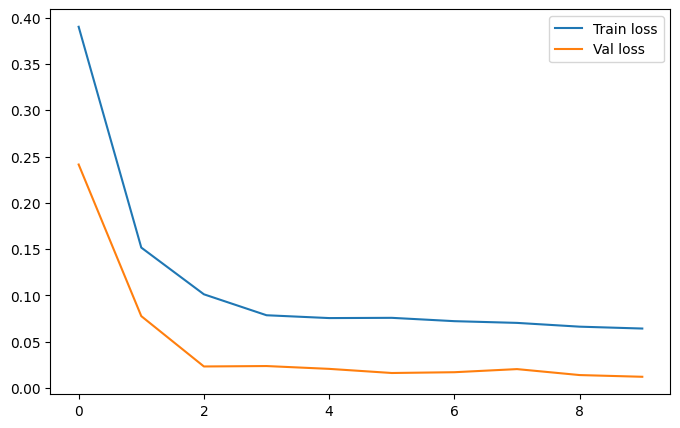

In [69]:
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

In [35]:
# Faire de la prediction
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_db = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [89]:
n_past = 3
n_day_to_pred = 30

pred_period_date = pd.date_range(list(train_dates)[-n_past], periods = n_day_to_pred, freq = us_db).tolist()
print(pred_period_date)

[Timestamp('2023-05-17 00:00:00', freq='C'), Timestamp('2023-05-18 00:00:00', freq='C'), Timestamp('2023-05-19 00:00:00', freq='C'), Timestamp('2023-05-22 00:00:00', freq='C'), Timestamp('2023-05-23 00:00:00', freq='C'), Timestamp('2023-05-24 00:00:00', freq='C'), Timestamp('2023-05-25 00:00:00', freq='C'), Timestamp('2023-05-26 00:00:00', freq='C'), Timestamp('2023-05-30 00:00:00', freq='C'), Timestamp('2023-05-31 00:00:00', freq='C'), Timestamp('2023-06-01 00:00:00', freq='C'), Timestamp('2023-06-02 00:00:00', freq='C'), Timestamp('2023-06-05 00:00:00', freq='C'), Timestamp('2023-06-06 00:00:00', freq='C'), Timestamp('2023-06-07 00:00:00', freq='C'), Timestamp('2023-06-08 00:00:00', freq='C'), Timestamp('2023-06-09 00:00:00', freq='C'), Timestamp('2023-06-12 00:00:00', freq='C'), Timestamp('2023-06-13 00:00:00', freq='C'), Timestamp('2023-06-14 00:00:00', freq='C'), Timestamp('2023-06-15 00:00:00', freq='C'), Timestamp('2023-06-16 00:00:00', freq='C'), Timestamp('2023-06-20 00:00:00'

In [90]:
prediction = model.predict(X_train[-n_day_to_pred:])

1/1 [==============================] - 0s 26ms/step


In [92]:
# transformation de données
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1) # repetition de la colonne de la prediction en 4 colonne définis avant transformation
y_pred_future = sc.inverse_transform(prediction_copies)[:,0]

In [93]:
# Transformer les detes dans les dates de prediction
forecast_date = []
for time_i in pred_period_date:
  forecast_date.append(time_i.date())

df_fortecast = pd.DataFrame({'Date': np.array(forecast_date), 'Open': y_pred_future})
df_fortecast['Date'] = pd.to_datetime(df_fortecast['Date'])

In [94]:
forecast_date

[datetime.date(2023, 5, 17),
 datetime.date(2023, 5, 18),
 datetime.date(2023, 5, 19),
 datetime.date(2023, 5, 22),
 datetime.date(2023, 5, 23),
 datetime.date(2023, 5, 24),
 datetime.date(2023, 5, 25),
 datetime.date(2023, 5, 26),
 datetime.date(2023, 5, 30),
 datetime.date(2023, 5, 31),
 datetime.date(2023, 6, 1),
 datetime.date(2023, 6, 2),
 datetime.date(2023, 6, 5),
 datetime.date(2023, 6, 6),
 datetime.date(2023, 6, 7),
 datetime.date(2023, 6, 8),
 datetime.date(2023, 6, 9),
 datetime.date(2023, 6, 12),
 datetime.date(2023, 6, 13),
 datetime.date(2023, 6, 14),
 datetime.date(2023, 6, 15),
 datetime.date(2023, 6, 16),
 datetime.date(2023, 6, 20),
 datetime.date(2023, 6, 21),
 datetime.date(2023, 6, 22),
 datetime.date(2023, 6, 23),
 datetime.date(2023, 6, 26),
 datetime.date(2023, 6, 27),
 datetime.date(2023, 6, 28),
 datetime.date(2023, 6, 29)]

In [96]:
original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date']>= '2022-12-15']

In [97]:
original.head()

,Date,Open
648,2022-12-15,41.700001
649,2022-12-16,41.000000
650,2022-12-19,41.250000
651,2022-12-20,39.360001
652,2022-12-21,39.810001


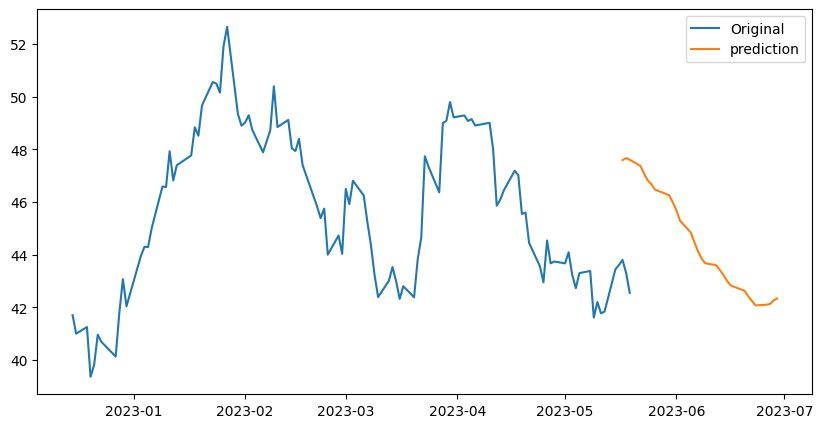

In [99]:
plt.figure(figsize = (10,5))
plt.plot(original['Date'], original['Open'], label = 'Original')
plt.plot(df_fortecast['Date'], df_fortecast['Open'], label = 'prediction')
plt.legend()
plt.show()